In [4]:
import numpy as np
import random 
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

AttributeError: module 'tensorflow' has no attribute 'disable_v2_behavior'

In [9]:
class Bandit:
    
    def __init__(self, k):
        """
        k: number of bandits 
        """
        self.k = k
        self.mean_sd_list = [] # Storing mean and sf of each bandit
        
        max_mean = 0
        self.max_i = 0
        
        for i in range(k):
            mean = random.uniform(-1, 1)
            sigma = random.uniform(0, 2)
            self.mean_sd_list.append((mean, sigma))
            
            if mean > max_mean:
                max_mean = mean
                self.max_i = i
        
    def generate_reward(self, i):
        mu, sigma = self.mean_sd_list[i]
        return np.random.normal(mu, sigma)
    
    def generate_optimum_reward(self):
        return self.generate_reward(self.max_i)

In [10]:
class Solver(object):
    
    def __init__(self, bandit):
        """
        bandit(object of class Bandit) to solve
        """
        
        self.bandit = bandit
        
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
    
    def update_regret(self, r):
        self.cumulative_regret += self.bandit.generate_optimum_reward() - r
        self.cumulative_regret_list.append(self.cumulative_regret)
    
    def update_reward(self, r):
        self.cumulative_reward += r
        self.t = np.sum(self.counts)
        self.avg_reward_list.append(self.cumulative_reward / self.t)
        
    def run_one_step(self):
        pass
    
    def run(self, num_steps):
        
        for _ in range(num_steps):
            i, r = self.run_one_step()
            self.counts[i] += 1 
            self.update_regret(r)
            self.update_reward(r)
            self.actions.append(i)

    # Functions to average results over num_avg times        
    # Reset parameters
    def reinit(self):
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
        
    def avg_run(self, num_steps, num_avg):
        avg_list = [0] * num_steps
        for _ in range(num_avg):
            self.reinit()
            self.run(num_steps)
            for i in range(num_steps):
#                 avg_list[i] += self.avg_reward_list[i]
                avg_list[i] += self.cumulative_regret_list[i]
        
        avg_list = [x/num_avg for x in avg_list]
        return avg_list

In [13]:
class EpsilonGreedy(Solver):
    
    def __init__(self, bandit, epsilon, time_variant_epsilon, init_trials):
        super().__init__(bandit)
        self.bandit = bandit
        self.epsilon = epsilon
        self.time_variant_epsilon = time_variant_epsilon
        self.mean_estimate = [0] * self.bandit.k
        self.t = 0
        
        self.set_inital_estimate(init_trials)
#         print("Initial estimate = ", self.mean_estimate)
    
    def set_inital_estimate(self, trials):
        for _ in range(trials):
            for i in range(self.bandit.k):
                r = self.bandit.generate_reward(i)
                self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

    def run_one_step(self):
        # Exploration
        if np.random.random() < self.epsilon:
            i = np.random.randint(0, self.bandit.k)
        # Exploitation
        else:
            # Pick the one with max probabilities
            i = max(range(self.bandit.k), key = lambda x: self.mean_estimate[x])
        
        r = self.bandit.generate_reward(i)
        self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

        self.t += 1        
        if self.time_variant_epsilon:
            self.epsilon = self.epsilon/self.t

        return i, r

In [17]:
class UCB(Solver):

    def __init__(self, bandit):
        super().__init__(bandit)
        self.t = 0
        self.mean_estimate = [0] * self.bandit.k
        
#     def set_inital_estimate(self, trials):
#         for _ in range(trials):
#             for i in range(self.bandit.k):
#                 r = self.bandit.generate_reward(i)
#                 self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

    def run_one_step(self):
        # Exploration
        i = max(range(self.bandit.k), key = lambda x: self.mean_estimate[x] + self.bandit.mean_sd_list[x][1] * np.sqrt(2 * np.log(self.t + 1)/ self.counts[x]))
        
        r = self.bandit.generate_reward(i)
        self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

        self.t += 1        
        return i, r

In [1]:
# Launch the tensorflow graph
class PolicyGradient(Solver):
    
    def __init__(self, bandit, total_episodes = 1000, epsilon = 0.3):

        tf.reset_default_graph()
        self.total_episodes = total_episodes
        self.epsilon = epsilon
        self.bandit = self.bandit.k
        
    def run_one_step(self):
        
        num_bandits = self.bandit.k

        # Initial weights and action
        weights = tf.Variable(tf.ones([num_bandits]))
        # print("Initial weights", weights)

        chosen_action = tf.argmax(weights,0)
        # print("Action:", chosen_action)

        reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
        action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
        # lr = tf.placeholder(shape=[1],dtype=tf.int32)
        lr = 0.001
        responsible_weight = tf.slice(weights,action_holder,[1])

        # Loss function and update
        loss = -(tf.log(responsible_weight)*reward_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        update = optimizer.minimize(loss)

        total_reward = np.zeros(num_bandits) # Scoreboard for bandits set to 0.
        alpha = 0.001 

        init = tf.initialize_all_variables()

        with tf.Session() as sess:
            sess.run(init)
            i = 0
            while i < total_episodes:
              # Choose action using e-greedy
              if np.random.rand(1) < epsilon:
                  action = np.random.randint(num_bandits)
              else:
                  action = sess.run(chosen_action)

              reward = get_reward(action, mu_sigma_dict)

              #  Update the network.
              new_update, resp_weight, weights = sess.run([update, responsible_weight, weights], feed_dict={reward_holder:[reward],action_holder:[action]})

              #Update our running tally of scores.
              total_reward[action] += reward
              # if i % 50 == 0:
              #     print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
              i+=1

        reward_sum = sum(total_reward)
        return reward_sum, weights

IndentationError: expected an indented block (<ipython-input-1-b6c3de8cc0e1>, line 4)

In [8]:
# Launch the tensorflow graph

def policy_gradient(mu_sigma_dict, total_episodes = 1000, epsilon = 0.3):
    tf.reset_default_graph()

    num_bandits = len(mu_sigma_dict.keys())

    # Initial weights and action

    weights = tf.Variable(tf.ones([num_bandits]))
    # print("Initial weights", weights)

    chosen_action = tf.argmax(weights,0)
    # print("Action:", chosen_action)

    reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
    action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
    # lr = tf.placeholder(shape=[1],dtype=tf.int32)
    lr = 0.001
    responsible_weight = tf.slice(weights,action_holder,[1])

    # Loss function and update
    loss = -(tf.log(responsible_weight)*reward_holder)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    update = optimizer.minimize(loss)

    total_reward = np.zeros(num_bandits) # Scoreboard for bandits set to 0.
    alpha = 0.001 

    init = tf.initialize_all_variables()

    with tf.Session() as sess:
      sess.run(init)
      i = 0
      while i < total_episodes:

          # Choose action using e-greedy
          if np.random.rand(1) < epsilon:
              action = np.random.randint(num_bandits)
          else:
              action = sess.run(chosen_action)

          reward = get_reward(action, mu_sigma_dict)

          #  Update the network.
          new_update, resp_weight, weights = sess.run([update, responsible_weight, weights], feed_dict={reward_holder:[reward],action_holder:[action]})

          #Update our running tally of scores.
          total_reward[action] += reward
          # if i % 50 == 0:
          #     print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
          i+=1

    reward_sum = sum(total_reward)
    return reward_sum, weights

In [18]:
def main(k, n):
    """
    k = number of bandits
    n = time steps
    """
    
    # defining object of class Bandit 
    bandit = Bandit(k) 
    print("Guassian distribution of bandits = \n", bandit.mean_sd_list)
    
    solvers = [EpsilonGreedy(bandit, epsilon = 0.0, init_trials = 1, time_variant_epsilon = False), 
#           EpsilonGreedy(bandit, epsilon = 0.01, init_trials = 1, time_variant_epsilon = False), 
          EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
#           EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = True),
#             UCB(bandit)
              ]
    
    # Solve for each of the object
    for s in solvers:
        s.run(n)
    
    # Plot average reward for each solver
    plt.figure(figsize = (10, 8))
    colors = ['k', 'b', 'r', 'y']
    labels = ['Epsilon = 0.0', 'Epsilon = 0.1 (time variant)', 'UCB']
    i = 0
    for s in solvers:
        plt.plot(s.avg_reward_list[100:], color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.title("Average Reward vs steps for {} bandits".format(k))
    plt.show()
    
    
    # Plot cumulative regret for each solver
    plt.figure(figsize = (10, 8))
    i = 0
    for s in solvers:
        plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.title("Cumulative regret vs steps for {} bandits".format(k))
    plt.show()

Guassian distribution of bandits = 
 [(-0.16326660850638675, 1.9026933397067043), (0.005570301660296151, 1.2422793579074491), (-0.593133694710354, 1.3826702121621572), (-0.6406459224447374, 1.2869677785759943), (0.01370956937032064, 0.25660488578271856), (-0.7655432191239862, 0.5612161098364892), (-0.3060712101845282, 0.18468225877580102), (0.8499216822609041, 0.08183769078117975)]


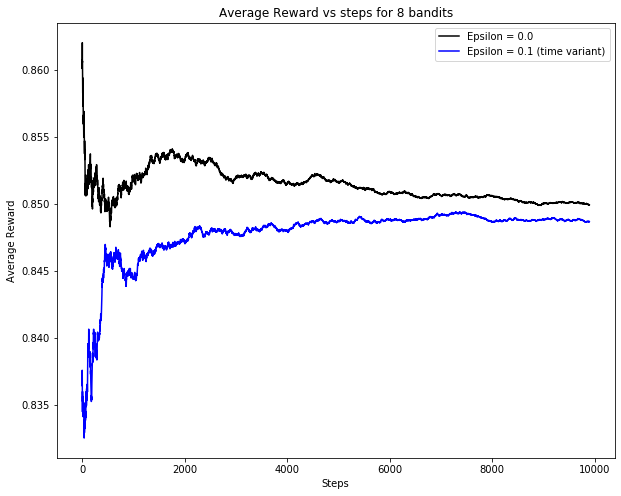

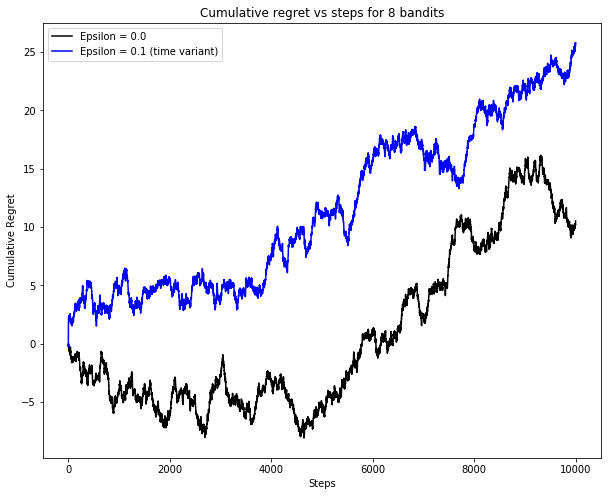

In [19]:
main(k = 8, n = 10000)

## Taking average over 2000 steps

Guassian distribution of bandits = 
 [(2.611436570481459, 0.3218365823960678), (0.7207133102562624, 1.9567892040087644)]


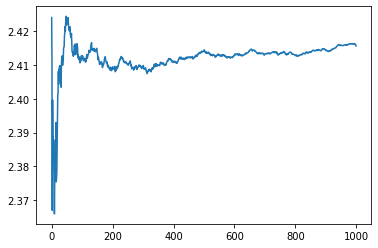

In [146]:
bandit = Bandit(k)

print("Guassian distribution of bandits = \n", bandit.mean_sd_list)

epsilon_greedy_solver = EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = False)
l = epsilon_greedy_solver.avg_run(n, 100)

# plt.plot(epsilon_greedy_solver.avg_reward_list)
plt.plot(l)

In [31]:
k = 8
n = 10000
avg_over = 10
bandit = Bandit(k)

print("Guassian distribution of bandits = \n", bandit.mean_sd_list)

colors = ['k', 'b', 'r', 'y']
labels = ['Epsilon = 0.0', 'Epsilon = 0.01', 'Epsilon = 0.1 (time variant)', 'Epsilon = 0.2 (time variant)']

solvers = [EpsilonGreedy(bandit, epsilon = 0.0, init_trials = 1, time_variant_epsilon = False), 
#           EpsilonGreedy(bandit, epsilon = 0.01, init_trials = 1, time_variant_epsilon = False), 
#           EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
          EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = True),
          UCB(bandit)]

Guassian distribution of bandits = 
 [(0.8422379496231822, 0.9611357264423923), (0.7845734320062638, 0.31552743191285515), (0.28703682993157154, 1.4488517170709818), (0.39428627922979587, 1.5176749704701271), (-0.32421306018300355, 0.1290108353503543), (0.6750448588808391, 0.004822685609616295), (0.810831410211567, 0.5101651011752486), (0.5947984256222278, 1.2092265990957387)]


In [32]:
avg_list = []
for s in solvers:
    l = s.avg_run(n, avg_over)
    avg_list.append(l)

/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


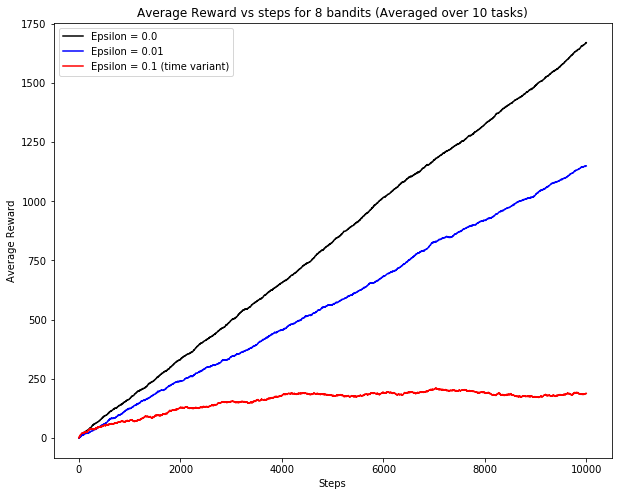

In [33]:
plt.figure(figsize = (10, 8))
for i, l in enumerate(avg_list):
    plt.plot(l, color = colors[i], label = labels[i])
    
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
plt.show()

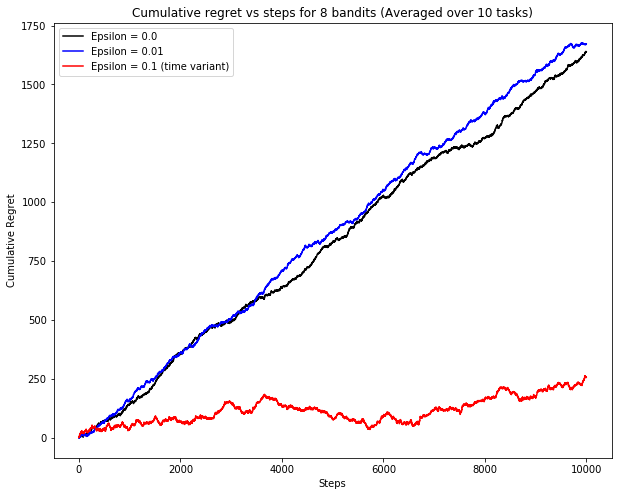

In [34]:
plt.figure(figsize = (10, 8))
i = 0
for s in solvers:
    plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
    i += 1
    
plt.xlabel("Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Cumulative regret vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
plt.show()